## Sources

- [Langchain](https://python.langchain.com/v0.2/docs/introduction/)🦜
- [Langgraph](https://langchain-ai.github.io/langgraph/tutorials/introduction/)🕸️
- [Langsmith](https://docs.smith.langchain.com/)🛠️

## Levels of automation
<div style="text-align:center">
    <img src="./images/LevelsOfAutomation.png" alt="levels of automation" width='80%'>
</div>

### Install the required packages

In [ ]:
%pip install -U langgraph langsmith langchain_openai langchain_community

### Set environment variables

In [1]:
import os

os.environ["LANGCHAIN_API_KEY"] = "ahah"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

OPENAI_API_KEY = os.getenv("COGITO_OPENAI_API_KEY")

### 1. The State of the graph
The first thing you do when you define a graph is define the `State` of the graph. The `State` consists of the schema of the graph as well as `reducer functions` which specify how to apply updates to the state. The schema of the `State` will be the input schema to all `Nodes` and `Edges` in the graph, and can be either a `TypedDict` or a `Pydantic` model. All `Nodes` will emit updates to the `State` which are then applied using the specified reducer function.

Source: [Langchain AI - State of the graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)


In [4]:
from typing import Annotated
from typing import TypedDict
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

### 2. Nodes for the graph
In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).

Source: [Langchain AI - Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes)

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name="gpt-4o-mini",
)

def chatbot(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm.invoke(state["messages"])]}

### 3. Edges - The workflow of the graph
Edges define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- **Normal Edges**: Go directly from one node to the next.
- **Conditional Edges**: Call a function to determine which node(s) to go to next.
- **Entry Point**: Which node to call first when user input arrives.
- **Conditional Entry Point**: Call a function to determine which node(s) to call first when user input arrives.

A node can have **MULTIPLE** outgoing edges. If a node has multiple out-going edges, **all** of those destination nodes will be executed in parallel as a part of the next superstep.

Source: [Langchain AI - Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges)

In [6]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# Adding nodes to the workflow
workflow.add_node("chatbot", chatbot)

# Defining edges between nodes
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

graph = workflow.compile()


### Lets take a look at our graph

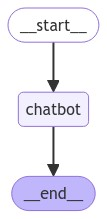

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke/stream the graph
LangGraph is built with first class support for streaming. There are several different ways to stream back results from the graph.

Source: [Langchain AI - Streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)

In [8]:
while True:
    user_input = input("User: ")
    print("User: " + user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: hei på deg


Failed to batch ingest runs: LangSmithError('Failed to POST https://api.smith.langchain.com/runs/batch in LangSmith API. HTTPError(\'403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Forbidden"}\')')


Assistant: Hei! Hvordan kan jeg hjelpe deg i dag?


Failed to batch ingest runs: LangSmithError('Failed to POST https://api.smith.langchain.com/runs/batch in LangSmith API. HTTPError(\'403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Forbidden"}\')')


User: 1


Failed to batch ingest runs: LangSmithError('Failed to POST https://api.smith.langchain.com/runs/batch in LangSmith API. HTTPError(\'403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Forbidden"}\')')


Assistant: Hello! It seems like you entered "1." How can I assist you today?


Failed to batch ingest runs: LangSmithError('Failed to POST https://api.smith.langchain.com/runs/batch in LangSmith API. HTTPError(\'403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Forbidden"}\')')


User: q
Goodbye!


### 4. Lets add tools to the graph

It's extremely common to want agents to do tool calling. Tool calling refers to choosing from several available tools, and specifying which ones to call and what the inputs should be. This is extremely common in agents, as you often want to let the LLM decide which tools to call and then call those tools.

Source: [Langchain AI - Tools](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling)

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3)
tools = [tool]

In [10]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

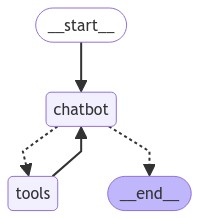

In [12]:
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(GraphState)

# Adding nodes to the workflow
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", ToolNode(tools))

# Defining edges between nodes
workflow.add_edge(START, "chatbot")
workflow.add_edge("tools", "chatbot")

# Defining conditional edges
workflow.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://www.nettavisen.no/nyheter/store-odeleggelser/s/5-95-1999464", "content": "Nyheter \u2304 Ukraina ... Notodden - Store \u00f8deleggelser Det jobbes n\u00e5 p\u00e5 spreng fra veitrafikkansatte og n\u00f8detater for \u00e5 f\u00e5 bukt med oversv\u00f8mmelsene rundt om i byen. 04.09.24 05:20"}, {"url": "https://www.telen.no/notodden", "content": "Notodden; Notodden FK; Nyheter; N\u00e6ringsliv; Sauherad; Sport; Stilling ledig; Telen p\u00e5 Facebook; Tips oss; Ukens papirannonser. V\u00e5re steder og aviser. Telemarksavisa; Rjukan Arbeiderblad; ... Notodden-mann vant 1,4 millioner: -\u2060 K\u00f8dder du n\u00e5 eller? Gylne tider: Hund - en kj\u00e6rkommen f\u00f8lgesvenn gjennom tykt og tynt ..."}, {"url": "https://www.nrk.no/vestfoldogtelemark/styrtregn-skaper-trobbel-pa-ostlandet-1.17029590", "content": "VANNET FOSSER: I Notodden har det kommet store nedb\u00f8rsmengder i natt. Her er fosser vannet ned E134 ved Notodden sentrum onsdag morgen. 

## TASK 1: CREATE YOUR OWN TOOL

#### Suggestions:

**Easy:**
1. Create a tool that performs a simple mathematical operation (e.g. addition, matrix multiplication, etc.)

**Medium:**
1. Create a tool that performs a simple data analysis operation (e.g. Pandas.DataFrame.describe())

**Hard:**
1. Create a tool that writes and executes python code.

<br>

**Example tool:**
```python
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b
```

#### Documentation:
- [Langchain AI - Tools](https://python.langchain.com/v0.2/docs/how_to/tool_calling/)

In [36]:
from langchain_core.tools import tool
from typing import Annotated


@tool
#-----------TASK 1: Write your own tool--------------
def my_tool():
    """Your tool description here"""
    pass
#-----------------------------------------------------

tools = [my_tool]

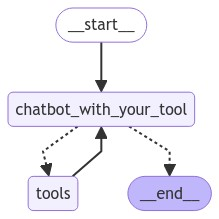

In [29]:

llm_with_your_tool = llm.bind_tools(tools)

def chatbot_with_your_tool(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm_with_your_tool.invoke(state["messages"])]}

workflow = StateGraph(GraphState)

workflow.add_node("chatbot_with_your_tool", chatbot_with_your_tool)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "chatbot_with_your_tool")
workflow.add_edge("tools", "chatbot_with_your_tool")

workflow.add_conditional_edges(
    "chatbot_with_your_tool",
    tools_condition
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
user_input = input("User: ")
for event in graph.stream({"messages": [("user", user_input)]}):
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: 4
Assistant: 2 + 2 er lik 4.


### Congratulations🎉 You have now created your first tool.

# Structured output

It's pretty common to want LLMs inside nodes to return structured output when building agents. This is because that structured output can often be used to route to the next step (e.g. choose between two different edges) or update specific keys of the state.

Source: [Langchain AI - Structured output](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#structured-output)

A structured output for weather might look like this:
```json
{
  "temperature": 25,
  "humidity": 0.5,
  "wind_speed": 10,
  "wind_direction": "N"
}


In [57]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List


class ResumeSummary(BaseModel):
    name: str = Field(..., title="Name if the applicant")
    experience: List[str] = Field(..., title="List of experiences")
    skills: List[str] = Field(..., title="List of skills")

Using the LangChain `.with_structured_output()` method, we can specify the output format of the tool. This will allow us to generate structured output from the tool.

In [58]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""
    {application}
    """
)
chain = prompt | llm.with_structured_output(ResumeSummary)

Lets load some applications and test the structured output.

In [62]:

applications = []
folder_path = os.path.join("data", "applications")
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            applications.append(file.read())

for application in applications:
    print(application)
    print(chain.invoke(application).json(indent=2))
    print("\n")


Hi! I’m Emily Davis and I’ve been a Senior Data Scientist for 8 years, mostly in the e-commerce sector. My main strengths are deep learning and data visualization. I’ve also worked with Python and TensorFlow extensively. I completed a PhD in Machine Learning and my last project was a demand prediction model that helped reduce stockouts by 20%. I’m looking to branch out into other industries, and I think this role is the perfect opportunity to apply my skills in new and challenging ways.
{
  "name": "Emily Davis",
  "experience": [
    "Senior Data Scientist for 8 years in the e-commerce sector",
    "Completed a PhD in Machine Learning",
    "Developed a demand prediction model that reduced stockouts by 20%"
  ],
  "skills": [
    "deep learning",
    "data visualization",
    "Python",
    "TensorFlow"
  ]
}


Hello, I’m David Lee, I’ve been working in data science for about 5 years now, mainly focusing on natural language processing (NLP). I have hands-on experience with Python, PyTo

## Task 2: **Create a Structured Output from Unstructured Emails**

You are provided with 5 `.txt` files, each containing an email about an office supply order. The emails may include:

- Product names, quantities
- Delivery dates, addresses
- Customer details (names, contacts)

Your task is to create a structured object that captures the relevant data (e.g., products, quantities, delivery info) while handling potential noise and inconsistencies. The structure should be designed for future analysis and flexibility to deal with incomplete or messy information.

### Example Output:
```json
{
    "customer": {
        "name": "John Doe", 
        "company": "ACME Corp"
    },
    "order_items": [
        {
            "product": "Pens",
            "quantity": 10
        }
    ],
    "delivery": {
        "address": "123 Main St",
        "date": "2023-09-12"
    }
}
```

#### Documentation:

- [Langchain AI - Structured Output](https://python.langchain.com/v0.2/docs/how_to/structured_output/)


In [66]:
orders = []
folder_path = os.path.join("data", "orders")
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            orders.append(file.read())

# See how one of the orders look
print(orders[0])

Hey,

Can I get 10 laptops? Also, maybe 100 notebooks? I'm not sure about the address right now, but it should be the one we always use. 

Delivery date... well, I guess sometime next week. 

Let me know if you need more info.
-Tom



You job now is to create the Pydantic object that will be used to structure the information in the emails.

In [68]:
#-----------TASK 2: Write your pydantic object --------------
class Order(BaseModel):
    pass
#------------------------------------------------------------

In [69]:
prompt = PromptTemplate(
    template="""
    {order}
    """
)
chain = prompt | llm.with_structured_output(Order)

In [70]:
orders[0]
print(chain.invoke(orders[0]).json(indent=2))

{}


# Basic Reflection

<div style="text-align:center">
    <img src="./images/Reflection.png" alt="basic agent reflection" width='50%'>
</div>


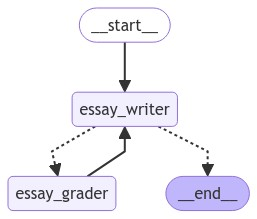

In [44]:
llm_gpt_3_5 = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name="gpt-3.5-turbo",
)

def essay_writer(state: GraphState):
    """Node that generate a 3 paragraph essay"""
    prompt = PromptTemplate(
        template="""
        Write a 3 paragraph essay based on the following request:

        Request: {messages}
        """
    )
    generate = prompt | llm_gpt_3_5
    response = generate.invoke({"messages": state["messages"]})
    print(response)
    return {"messages": [response]}


def essay_grader(state: GraphState):
    """Node that grades an essay"""
    prompt = PromptTemplate(
        template="""
        Grade the following essay:

        Essay: {messages}
        """
    )
    generate = prompt | llm
    response = generate.invoke({"messages": state["messages"]})
    return {"messages": [response]}


def should_continue(state: GraphState):
    """Node that checks if the user wants to continue"""
    if len(state["messages"]) > 6:
        return "__end__"
    else:
        "essay_grader"


workflow = StateGraph(GraphState)

workflow.add_node("essay_writer", essay_writer)
workflow.add_node("essay_grader", essay_grader)

workflow.add_edge(START, "essay_writer")
workflow.add_edge("essay_grader", "essay_writer")

workflow.add_conditional_edges(
    "essay_writer",
    should_continue
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
request = "Write an essay on the importance of education in society."

for event in graph.stream({"messages": [("user", request)]}):
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

content='Education plays a vital role in shaping society and individuals. It provides the necessary knowledge and skills that empower individuals to contribute positively to their communities and the world at large. Education equips individuals with critical thinking, problem-solving, and communication skills that are essential for personal and professional growth. In a rapidly changing world, education is the key to adapting to new technologies and innovations.\n\nFurthermore, education is a powerful tool for promoting equality and social justice. It provides opportunities for individuals from diverse backgrounds to access resources and improve their socioeconomic status. Education can break the cycle of poverty and empower individuals to create a better future for themselves and their families. By investing in education, societies can reduce inequality, promote social mobility, and create a more inclusive and cohesive community.\n\nIn addition, education plays a crucial role in foste

ValueError: Branch did not return a valid destination